# Databricks Job & Workflow Health Monitor

## Overview

This notebook provides a **comprehensive health assessment** of all Databricks jobs and workflows by analyzing job configurations, run history, success rates, execution times, failure patterns, and resource utilization. The output includes detailed reports identifying problematic jobs, performance bottlenecks, optimization opportunities, and actionable recommendations.

**✨ Enterprise-grade job monitoring with success rate tracking, SLA violation detection, failure analysis, and performance optimization recommendations.**

---

## Features

### Core Functionality
* **Job Inventory**: Complete list of all jobs with metadata
* **Run History Analysis**: Analyzes job runs over configurable time period (default: 30 days)
* **Success Rate Tracking**: Calculates success/failure rates per job
* **Execution Time Analysis**: Average, min, max, trend analysis
* **Failure Pattern Detection**: Identifies common failure reasons
* **SLA Violation Detection**: Flags jobs exceeding execution time thresholds
* **Orphaned Job Detection**: Jobs with inactive or missing owners
* **Retry Analysis**: Jobs with excessive retry attempts

### Health Metrics
* **Overall Health Score**: 0-100 score based on success rates and performance
* **Job Status Distribution**: Active, paused, failed jobs
* **Success Rate by Job**: Individual job performance tracking
* **Execution Time Trends**: Identify degrading performance
* **Failure Rate Trends**: Spot increasing failure patterns
* **Resource Utilization**: Cluster usage, DBU consumption patterns

### Analysis & Insights
* **Problem Jobs**: High failure rate (>20%), slow execution, frequent retries
* **At-Risk Jobs**: Declining success rates, increasing execution times
* **Optimization Opportunities**: Over-provisioned clusters, inefficient schedules
* **Dependency Analysis**: Job dependencies and potential bottlenecks
* **Schedule Analysis**: Overlapping jobs, peak usage times
* **Owner Analysis**: Jobs per owner, orphaned jobs

### Recommendations
* **Critical Issues**: Jobs failing >50% of runs
* **Performance Issues**: Jobs with 2x+ execution time increase
* **Configuration Issues**: Missing retries, no timeout, no alerts
* **Optimization Suggestions**: Cluster right-sizing, schedule optimization

### Export Formats
* **Delta Table**: Historical tracking with append mode
* **Excel Workbook**: Multi-sheet report with:
  * Job Inventory
  * Run History Summary
  * Problem Jobs
  * Health Metrics
  * Recommendations
  * Execution Statistics
* **Interactive Visualizations**: Success rate trends, execution time charts

---

## Version Control

| Version | Date | Author | Changes |
|---------|------|--------|---------|  
| 1.0.0 | 2026-02-16 | Assistant | Comprehensive job and workflow health monitoring system with complete coverage of all workspace jobs. Features include: job inventory with metadata (name, owner, schedule, cluster config), run history analysis (configurable lookback period, default 30 days), success rate calculation per job, execution time analysis (average, min, max, percentiles, trends), failure pattern detection and categorization, SLA violation detection (configurable thresholds), orphaned job identification, retry analysis, health scoring (0-100 weighted system), problem job identification (high failure rate >20%, slow execution, excessive retries), at-risk job detection (declining trends), optimization recommendations (cluster right-sizing, schedule conflicts), dependency analysis, schedule overlap detection, owner analysis, multiple export formats (Delta table with historical append, Excel multi-sheet workbook), interactive visualizations (matplotlib charts), job mode support with automatic configuration, serverless compute optimization, parallel API calls with ThreadPoolExecutor, retry logic with exponential backoff, progress tracking, execution statistics, configuration validation, and comprehensive error handling. |

---

## Configuration

### Widget Parameters:
* `lookback_days` - Days of run history to analyze (default: 30)
* `failure_threshold` - Failure rate % to flag as problem (default: 20)
* `slow_job_threshold_minutes` - Execution time threshold for slow jobs (default: 60)
* `output_catalog` - Target catalog for Delta table (default: main)
* `output_schema` - Target schema for Delta table (default: default)

### Performance Settings:
* `MAX_JOBS = 999` - Maximum jobs to analyze (999 = all)
* `MAX_RUNS_PER_JOB = 100` - Maximum runs to analyze per job
* `MAX_WORKERS = 10` - Parallel threads for API calls
* `MAX_RETRIES = 3` - Retries for failed API calls
* `RETRY_DELAY = 2` - Seconds between retries

### Export Settings:
* `ENABLE_EXCEL_EXPORT = True` - Excel workbook generation
* `ENABLE_DELTA_EXPORT = True` - Delta table for historical tracking
* `ENABLE_VISUALIZATIONS = True` - Generate charts (interactive mode only)

### Analysis Thresholds:
* `FAILURE_RATE_CRITICAL = 50` - Critical failure rate %
* `FAILURE_RATE_WARNING = 20` - Warning failure rate %
* `EXECUTION_TIME_INCREASE_THRESHOLD = 2.0` - Flag if 2x+ slower
* `MIN_RUNS_FOR_ANALYSIS = 5` - Minimum runs needed for trend analysis

---

## Usage

### Interactive Mode
1. Configure widget parameters at the top
2. Run all cells to analyze job health
3. Review health metrics and problem jobs
4. View visualizations and trends
5. Download Excel report from export path

### Job Mode
1. Schedule as a Databricks job (daily/weekly recommended)
2. Set widget parameters in job configuration
3. Automatically runs comprehensive analysis
4. Exports to Delta table for historical tracking
5. Returns JSON summary for orchestration

---

## Key Features

✓ **Complete Job Coverage**: Analyzes all workspace jobs  
✓ **Configurable Lookback**: 7, 30, 60, or 90 day analysis periods  
✓ **Success Rate Tracking**: Per-job success/failure rates  
✓ **Execution Time Analysis**: Trends, anomalies, SLA violations  
✓ **Failure Pattern Detection**: Categorizes and analyzes failures  
✓ **Problem Job Identification**: High failure rate, slow execution  
✓ **Health Scoring**: 0-100 weighted health score  
✓ **Actionable Recommendations**: Prioritized by severity  
✓ **Historical Tracking**: Delta table with trend analysis  
✓ **Excel Reports**: Multi-sheet workbooks with analysis  
✓ **Interactive Visualizations**: Charts and graphs  
✓ **Parallel Processing**: Fast execution with ThreadPoolExecutor  
✓ **Retry Logic**: Resilient API calls with exponential backoff  
✓ **Job Mode Support**: Automated scheduled execution  
✓ **Serverless Optimized**: Compute-aware optimizations  
✓ **Owner Tracking**: Identifies orphaned jobs  
✓ **Schedule Analysis**: Detects overlapping jobs  
✓ **Configuration Validation**: Validates all parameters  
✓ **Comprehensive Error Handling**: Graceful degradation

In [0]:
%pip install openpyxl --quiet

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# ============================================================================
# IMPORTS
# ============================================================================

# Standard library
import time
import os
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

# Third-party
import pandas as pd
import pytz

# Databricks SDK
from databricks.sdk import WorkspaceClient
from databricks.sdk.errors import NotFound, PermissionDenied

# PySpark
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, TimestampType, DoubleType

# ============================================================================
# JOB MODE DETECTION (MUST BE FIRST)
# ============================================================================

try:
    dbutils.notebook.entry_point.getDbutils().notebook().getContext().currentRunId().isDefined()
    is_job_mode = True
except:
    is_job_mode = False

# ============================================================================
# SERVERLESS DETECTION
# ============================================================================

try:
    test_df = spark.range(1)
    test_df.cache()
    test_df.count()
    test_df.unpersist()
    is_serverless = False
except Exception as e:
    if 'PERSIST' in str(e).upper() or 'CACHE' in str(e).upper():
        is_serverless = True
    else:
        is_serverless = False

# ============================================================================
# TIMEZONE CONFIGURATION
# ============================================================================

TIMEZONE = 'America/New_York'
eastern = pytz.timezone(TIMEZONE)

# ============================================================================
# LOGGING FUNCTION
# ============================================================================

def log(message):
    """Print messages (always in interactive, selectively in job mode)"""
    print(message)

# ============================================================================
# CONFIGURATION PARAMETERS
# ============================================================================

# Analysis period
LOOKBACK_DAYS = 30  # Days of run history to analyze

# Job limits
MAX_JOBS = 999  # Maximum jobs to analyze (999 = all)
MAX_RUNS_PER_JOB = 25  # Maximum runs to fetch per job (API limit is 26)

# Performance settings
MAX_WORKERS = 10  # Parallel threads for API calls
MAX_RETRIES = 3  # Retries for failed API calls
RETRY_DELAY = 2  # Seconds between retries

# Health thresholds
FAILURE_RATE_CRITICAL = 50  # % - Critical failure rate
FAILURE_RATE_WARNING = 20  # % - Warning failure rate
SLOW_JOB_THRESHOLD_MINUTES = 60  # Minutes - Flag jobs exceeding this
EXECUTION_TIME_INCREASE_THRESHOLD = 2.0  # Flag if 2x+ slower than average
MIN_RUNS_FOR_ANALYSIS = 5  # Minimum runs needed for trend analysis

# Export settings (disabled in interactive mode, enabled in job mode)
EXPORT_PATH = '/dbfs/tmp/job_health_export'
if is_job_mode:
    ENABLE_EXCEL_EXPORT = True
    ENABLE_DELTA_EXPORT = True
    ENABLE_JSON_EXPORT = True
    log("🤖 Job mode: Exports ENABLED")
else:
    ENABLE_EXCEL_EXPORT = False
    ENABLE_DELTA_EXPORT = False
    ENABLE_JSON_EXPORT = False
    log("💻 Interactive mode: Exports DISABLED")

ENABLE_VISUALIZATIONS = True

# Delta table configuration
DELTA_TABLE_NAME = 'main.default.job_health_history'

# ============================================================================
# EXECUTION STATISTICS
# ============================================================================

execution_stats = {
    'start_time': time.time(),
    'api_calls': 0,
    'api_failures': 0,
    'api_retries': 0,
    'jobs_processed': 0,
    'runs_processed': 0
}

# ============================================================================
# INITIALIZE SDK CLIENT
# ============================================================================

wc = WorkspaceClient()

log("\n" + "="*60)
log("JOB & WORKFLOW HEALTH MONITOR")
log("="*60)
log(f"Execution mode: {'JOB' if is_job_mode else 'INTERACTIVE'}")
log(f"Compute type: {'SERVERLESS' if is_serverless else 'TRADITIONAL'}")
log(f"Timezone: {TIMEZONE}")
log(f"Lookback period: {LOOKBACK_DAYS} days")
log(f"Analysis thresholds: Failure={FAILURE_RATE_WARNING}%, Slow={SLOW_JOB_THRESHOLD_MINUTES}min")
log(f"Excel export: {'ENABLED' if ENABLE_EXCEL_EXPORT else 'DISABLED'}")
log(f"Delta export: {'ENABLED' if ENABLE_DELTA_EXPORT else 'DISABLED'}")
log(f"JSON export: {'ENABLED' if ENABLE_JSON_EXPORT else 'DISABLED'}")
log("="*60)

💻 Interactive mode: Exports DISABLED

JOB & WORKFLOW HEALTH MONITOR
Execution mode: INTERACTIVE
Compute type: SERVERLESS
Timezone: America/New_York
Lookback period: 30 days
Analysis thresholds: Failure=20%, Slow=60min
Excel export: DISABLED
Delta export: DISABLED
JSON export: DISABLED


In [0]:
# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def log_execution_time(cell_name, start_time):
    """Log execution time for a cell"""
    elapsed = time.time() - start_time
    log(f"⏱️  {cell_name} completed in {elapsed:.2f} seconds")

def validate_dataframe_exists(df_name, df):
    """Validate that a DataFrame exists and has data"""
    if df is None:
        log(f"⚠️  Warning: {df_name} is None")
        return False
    try:
        count = df.count()
        if count == 0:
            log(f"⚠️  Warning: {df_name} is empty (0 rows)")
            return False
        return True
    except Exception as e:
        log(f"⚠️  Warning: Error checking {df_name}: {str(e)}")
        return False

def api_call_with_retry(func, *args, **kwargs):
    """Execute API call with retry logic and stats tracking"""
    for attempt in range(MAX_RETRIES):
        try:
            execution_stats['api_calls'] += 1
            result = func(*args, **kwargs)
            return result
        except Exception as e:
            execution_stats['api_failures'] += 1
            if attempt < MAX_RETRIES - 1:
                execution_stats['api_retries'] += 1
                time.sleep(RETRY_DELAY * (2 ** attempt))  # Exponential backoff
                log(f"  ⚠️  Retry {attempt + 1}/{MAX_RETRIES} after error: {str(e)[:100]}")
            else:
                log(f"  ✗ Failed after {MAX_RETRIES} attempts: {str(e)[:100]}")
                raise
    return None

def format_duration(seconds):
    """Format duration in human-readable format"""
    if seconds is None:
        return 'N/A'
    
    if seconds < 60:
        return f"{seconds:.0f}s"
    elif seconds < 3600:
        return f"{seconds/60:.1f}m"
    else:
        return f"{seconds/3600:.1f}h"

def calculate_health_score(success_rate, avg_duration_minutes, has_retries):
    """Calculate health score (0-100) for a job"""
    score = 0
    
    # Success rate component (0-60 points)
    if success_rate >= 95:
        score += 60
    elif success_rate >= 90:
        score += 50
    elif success_rate >= 80:
        score += 40
    elif success_rate >= 70:
        score += 30
    elif success_rate >= 50:
        score += 20
    else:
        score += 10
    
    # Performance component (0-30 points)
    if avg_duration_minutes < 10:
        score += 30
    elif avg_duration_minutes < 30:
        score += 25
    elif avg_duration_minutes < 60:
        score += 20
    elif avg_duration_minutes < 120:
        score += 15
    else:
        score += 10
    
    # Reliability component (0-10 points)
    if has_retries:
        score += 5  # Has retry configuration
    else:
        score += 10  # No retries needed
    
    return min(score, 100)

log("✓ Helper functions loaded")

✓ Helper functions loaded


In [0]:
cell_start_time = time.time()

log("\n" + "="*60)
log("FETCHING JOBS")
log("="*60)

try:
    # Fetch all jobs
    log("Fetching all jobs...")
    all_jobs = list(wc.jobs.list())
    
    if MAX_JOBS < 999:
        all_jobs = all_jobs[:MAX_JOBS]
        log(f"  Limited to {MAX_JOBS} jobs")
    
    log(f"✓ Fetched {len(all_jobs)} jobs")
    
    # Extract job metadata
    jobs_data = []
    for job in all_jobs:
        try:
            job_settings = job.settings
            
            # Extract max_retries from tasks if available
            max_retries = 0
            if job_settings and job_settings.tasks:
                # Get max retries across all tasks
                for task in job_settings.tasks:
                    task_retries = getattr(task, 'max_retries', 0)
                    if task_retries and task_retries > max_retries:
                        max_retries = task_retries
            
            jobs_data.append({
                'job_id': job.job_id,
                'job_name': job_settings.name if job_settings else 'Unknown',
                'creator': job.creator_user_name or 'Unknown',
                'created_time': datetime.fromtimestamp(job.created_time / 1000, tz=eastern) if job.created_time else None,
                'schedule': job_settings.schedule.quartz_cron_expression if (job_settings and job_settings.schedule) else None,
                'max_concurrent_runs': job_settings.max_concurrent_runs if job_settings else 1,
                'timeout_seconds': job_settings.timeout_seconds if job_settings else None,
                'max_retries': max_retries,
                'has_schedule': bool(job_settings and job_settings.schedule),
                'has_continuous': bool(job_settings and job_settings.continuous),
                'task_count': len(job_settings.tasks) if (job_settings and job_settings.tasks) else 0
            })
            
        except Exception as e:
            log(f"  ⚠️  Error processing job {job.job_id}: {str(e)[:100]}")
            continue
    
    # Create DataFrame
    jobs_df = spark.createDataFrame(jobs_data)
    
    log(f"✓ Processed {len(jobs_data)} jobs")
    log(f"  Scheduled jobs: {jobs_df.filter(F.col('has_schedule') == True).count()}")
    log(f"  Continuous jobs: {jobs_df.filter(F.col('has_continuous') == True).count()}")
    log(f"  Multi-task jobs: {jobs_df.filter(F.col('task_count') > 1).count()}")
    log(f"  Jobs with retries: {jobs_df.filter(F.col('max_retries') > 0).count()}")
    
    execution_stats['jobs_processed'] = len(jobs_data)
    
except Exception as e:
    log(f"✗ Error fetching jobs: {str(e)}")
    jobs_df = None

log_execution_time("Fetch Jobs", cell_start_time)


FETCHING JOBS
Fetching all jobs...
✓ Fetched 741 jobs
✓ Processed 741 jobs
  Scheduled jobs: 55
  Continuous jobs: 0
  Multi-task jobs: 0
  Jobs with retries: 0
⏱️  Fetch Jobs completed in 6.37 seconds


In [0]:
cell_start_time = time.time()

log("\n" + "="*60)
log(f"FETCHING JOB RUNS (LAST {LOOKBACK_DAYS} DAYS)")
log("="*60)

if jobs_df is not None:
    # Calculate start time for lookback period
    start_time_ms = int((datetime.now(eastern) - timedelta(days=LOOKBACK_DAYS)).timestamp() * 1000)
    
    log(f"Fetching runs since: {datetime.fromtimestamp(start_time_ms/1000, tz=eastern).strftime('%Y-%m-%d %H:%M:%S')}")
    
    all_runs = []
    job_ids = [row.job_id for row in jobs_df.select('job_id').collect()]
    
    log(f"Fetching runs for {len(job_ids)} jobs...")
    
    completed = 0
    
    def fetch_runs_for_job(job_id):
        """Fetch runs for a single job"""
        try:
            runs = list(wc.jobs.list_runs(
                job_id=job_id,
                start_time_from=start_time_ms,
                limit=MAX_RUNS_PER_JOB
            ))
            return runs
        except Exception as e:
            log(f"  ⚠️  Error fetching runs for job {job_id}: {str(e)[:100]}")
            return []
    
    # Parallel fetch with progress tracking
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        future_to_job = {executor.submit(fetch_runs_for_job, job_id): job_id for job_id in job_ids}
        
        for future in as_completed(future_to_job):
            completed += 1
            
            # Progress logging every 10% or every 50 jobs
            if completed % max(1, len(job_ids) // 10) == 0 or completed % 50 == 0:
                progress_pct = (completed / len(job_ids)) * 100
                log(f"  Progress: {completed}/{len(job_ids)} jobs ({progress_pct:.1f}%)")
            
            runs = future.result()
            if runs:
                all_runs.extend(runs)
    
    log(f"✓ Fetched {len(all_runs)} total runs across {len(job_ids)} jobs")
    
    # Process runs into structured data
    log("Processing run data...")
    runs_data = []
    
    for run in all_runs:
        try:
            # Calculate duration
            duration_ms = None
            if run.end_time and run.start_time:
                duration_ms = run.end_time - run.start_time
            
            runs_data.append({
                'run_id': run.run_id,
                'job_id': run.job_id,
                'run_name': run.run_name or 'Unknown',
                'state': run.state.life_cycle_state.value if run.state and run.state.life_cycle_state else 'UNKNOWN',
                'result_state': run.state.result_state.value if (run.state and run.state.result_state) else None,
                'start_time': datetime.fromtimestamp(run.start_time / 1000, tz=eastern) if run.start_time else None,
                'end_time': datetime.fromtimestamp(run.end_time / 1000, tz=eastern) if run.end_time else None,
                'duration_seconds': duration_ms / 1000 if duration_ms else None,
                'trigger': run.trigger.value if run.trigger else 'UNKNOWN',
                'run_type': run.run_type.value if run.run_type else 'UNKNOWN',
                'attempt_number': run.attempt_number or 0,
                'creator_user_name': run.creator_user_name or 'Unknown'
            })
            
        except Exception as e:
            log(f"  ⚠️  Error processing run {run.run_id}: {str(e)[:100]}")
            continue
    
    # Create DataFrame
    if runs_data:
        runs_df = spark.createDataFrame(runs_data)
        
        log(f"✓ Processed {len(runs_data)} runs")
        log(f"  Completed runs: {runs_df.filter(F.col('state') == 'TERMINATED').count()}")
        log(f"  Running: {runs_df.filter(F.col('state') == 'RUNNING').count()}")
        log(f"  Pending: {runs_df.filter(F.col('state') == 'PENDING').count()}")
        
        execution_stats['runs_processed'] = len(runs_data)
    else:
        log("⚠️  No runs found in the lookback period")
        runs_df = None
    
else:
    log("⚠️  Skipping run fetch (no jobs found)")
    runs_df = None

log_execution_time("Fetch Job Runs", cell_start_time)


FETCHING JOB RUNS (LAST 30 DAYS)
Fetching runs since: 2026-01-18 11:00:58
Fetching runs for 741 jobs...
  Progress: 50/741 jobs (6.7%)
  Progress: 74/741 jobs (10.0%)
  Progress: 100/741 jobs (13.5%)
  Progress: 148/741 jobs (20.0%)
  Progress: 150/741 jobs (20.2%)
  Progress: 200/741 jobs (27.0%)
  Progress: 222/741 jobs (30.0%)
  Progress: 250/741 jobs (33.7%)


/databricks/python/lib/python3.12/site-packages/databricks/sdk/errors/base.py:87: UserWarning: The 'retry_after_secs' parameter of DatabricksError is deprecated and will be removed in a future version.
  warnings.warn(


  Progress: 296/741 jobs (39.9%)
  Progress: 300/741 jobs (40.5%)
  Progress: 350/741 jobs (47.2%)
  Progress: 370/741 jobs (49.9%)
  Progress: 400/741 jobs (54.0%)
  Progress: 444/741 jobs (59.9%)
  Progress: 450/741 jobs (60.7%)
  Progress: 500/741 jobs (67.5%)
  Progress: 518/741 jobs (69.9%)
  Progress: 550/741 jobs (74.2%)
  Progress: 592/741 jobs (79.9%)
  Progress: 600/741 jobs (81.0%)
  Progress: 650/741 jobs (87.7%)
  Progress: 666/741 jobs (89.9%)
  Progress: 700/741 jobs (94.5%)
  Progress: 740/741 jobs (99.9%)
✓ Fetched 16579 total runs across 741 jobs
Processing run data...
✓ Processed 16579 runs
  Completed runs: 16027
  Running: 11
  Pending: 0
⏱️  Fetch Job Runs completed in 27.18 seconds


In [0]:
cell_start_time = time.time()

log("\n" + "="*60)
log("CALCULATING JOB HEALTH METRICS")
log("="*60)

if runs_df is not None and jobs_df is not None:
    # Join runs with jobs
    job_runs = runs_df.join(jobs_df, 'job_id', 'left')
    
    # Calculate metrics per job
    log("Calculating success rates and execution times...")
    
    job_metrics = job_runs.groupBy('job_id', 'job_name', 'creator', 'has_schedule', 'max_retries').agg(
        F.count('*').alias('total_runs'),
        F.sum(F.when(F.col('result_state') == 'SUCCESS', 1).otherwise(0)).alias('successful_runs'),
        F.sum(F.when(F.col('result_state') == 'FAILED', 1).otherwise(0)).alias('failed_runs'),
        F.sum(F.when(F.col('result_state') == 'TIMEDOUT', 1).otherwise(0)).alias('timeout_runs'),
        F.sum(F.when(F.col('result_state') == 'CANCELED', 1).otherwise(0)).alias('canceled_runs'),
        F.sum(F.when(F.col('state') == 'RUNNING', 1).otherwise(0)).alias('running_runs'),
        F.avg('duration_seconds').alias('avg_duration_seconds'),
        F.min('duration_seconds').alias('min_duration_seconds'),
        F.max('duration_seconds').alias('max_duration_seconds'),
        F.max('start_time').alias('last_run_time'),
        F.sum(F.when(F.col('attempt_number') > 0, 1).otherwise(0)).alias('retry_count')
    )
    
    # Calculate success rate and derived metrics
    job_metrics = job_metrics.withColumn(
        'success_rate',
        (F.col('successful_runs') / F.col('total_runs') * 100).cast('double')
    )
    
    job_metrics = job_metrics.withColumn(
        'failure_rate',
        (F.col('failed_runs') / F.col('total_runs') * 100).cast('double')
    )
    
    job_metrics = job_metrics.withColumn(
        'avg_duration_minutes',
        (F.col('avg_duration_seconds') / 60).cast('double')
    )
    
    # Calculate health score using UDF
    from pyspark.sql.functions import udf
    from pyspark.sql.types import IntegerType
    
    @udf(returnType=IntegerType())
    def calc_health_score(success_rate, avg_duration_minutes, max_retries):
        if success_rate is None or avg_duration_minutes is None:
            return 0
        return calculate_health_score(success_rate, avg_duration_minutes, max_retries > 0)
    
    job_metrics = job_metrics.withColumn(
        'health_score',
        calc_health_score(F.col('success_rate'), F.col('avg_duration_minutes'), F.col('max_retries'))
    )
    
    # Add health category
    job_metrics = job_metrics.withColumn(
        'health_category',
        F.when(F.col('health_score') >= 80, 'HEALTHY')
         .when(F.col('health_score') >= 60, 'FAIR')
         .when(F.col('health_score') >= 40, 'POOR')
         .otherwise('CRITICAL')
    )
    
    # Add problem flags
    job_metrics = job_metrics.withColumn(
        'is_problem_job',
        (F.col('failure_rate') > FAILURE_RATE_WARNING) | 
        (F.col('avg_duration_minutes') > SLOW_JOB_THRESHOLD_MINUTES)
    )
    
    log(f"✓ Calculated metrics for {job_metrics.count()} jobs")
    
    # Display summary statistics
    log("\nHealth Distribution:")
    health_dist = job_metrics.groupBy('health_category').count().orderBy(F.desc('count'))
    for row in health_dist.collect():
        log(f"  {row.health_category}: {row['count']} jobs")
    
    log(f"\nProblem Jobs: {job_metrics.filter(F.col('is_problem_job') == True).count()}")
    
    # Overall statistics
    total_runs = job_metrics.agg(F.sum('total_runs')).first()[0]
    total_success = job_metrics.agg(F.sum('successful_runs')).first()[0]
    total_failed = job_metrics.agg(F.sum('failed_runs')).first()[0]
    
    overall_success_rate = (total_success / total_runs * 100) if total_runs > 0 else 0
    
    log(f"\nOverall Statistics:")
    log(f"  Total runs analyzed: {total_runs:,}")
    log(f"  Successful: {total_success:,} ({overall_success_rate:.1f}%)")
    log(f"  Failed: {total_failed:,} ({(total_failed/total_runs*100) if total_runs > 0 else 0:.1f}%)")
    
else:
    log("⚠️  Skipping metrics calculation (no data)")
    job_metrics = None

log_execution_time("Calculate Metrics", cell_start_time)


CALCULATING JOB HEALTH METRICS
Calculating success rates and execution times...
✓ Calculated metrics for 220 jobs

Health Distribution:
  HEALTHY: 160 jobs
  POOR: 38 jobs
  FAIR: 18 jobs
  CRITICAL: 4 jobs

Problem Jobs: 61

Overall Statistics:
  Total runs analyzed: 16,579
  Successful: 16,012 (96.6%)
  Failed: 541 (3.3%)
⏱️  Calculate Metrics completed in 11.90 seconds


In [0]:
cell_start_time = time.time()

log("\n" + "="*60)
log("IDENTIFYING PROBLEM JOBS")
log("="*60)

if job_metrics is not None:
    # Critical jobs (failure rate > 50%)
    critical_jobs = job_metrics.filter(F.col('failure_rate') > FAILURE_RATE_CRITICAL)
    critical_count = critical_jobs.count()
    
    # Warning jobs (failure rate > 20%)
    warning_jobs = job_metrics.filter(
        (F.col('failure_rate') > FAILURE_RATE_WARNING) & 
        (F.col('failure_rate') <= FAILURE_RATE_CRITICAL)
    )
    warning_count = warning_jobs.count()
    
    # Slow jobs (avg execution > threshold)
    slow_jobs = job_metrics.filter(F.col('avg_duration_minutes') > SLOW_JOB_THRESHOLD_MINUTES)
    slow_count = slow_jobs.count()
    
    # Jobs with no recent runs
    stale_jobs = jobs_df.join(
        job_metrics.select('job_id'),
        'job_id',
        'left_anti'  # Jobs with no runs in lookback period
    )
    stale_count = stale_jobs.count()
    
    log(f"\n🔴 CRITICAL: {critical_count} jobs with >50% failure rate")
    if critical_count > 0:
        log("  Top 5 critical jobs:")
        for row in critical_jobs.orderBy(F.desc('failure_rate')).limit(5).collect():
            log(f"    - {row.job_name}: {row.failure_rate:.1f}% failure rate ({row.failed_runs}/{row.total_runs} runs)")
    
    log(f"\n🟡 WARNING: {warning_count} jobs with >20% failure rate")
    if warning_count > 0:
        log("  Top 5 warning jobs:")
        for row in warning_jobs.orderBy(F.desc('failure_rate')).limit(5).collect():
            log(f"    - {row.job_name}: {row.failure_rate:.1f}% failure rate")
    
    log(f"\n🐢 SLOW: {slow_count} jobs with avg execution >{SLOW_JOB_THRESHOLD_MINUTES} minutes")
    if slow_count > 0:
        log("  Top 5 slowest jobs:")
        for row in slow_jobs.orderBy(F.desc('avg_duration_minutes')).limit(5).collect():
            log(f"    - {row.job_name}: {row.avg_duration_minutes:.1f} min avg ({format_duration(row.max_duration_seconds)} max)")
    
    log(f"\n⏸️  STALE: {stale_count} jobs with no runs in last {LOOKBACK_DAYS} days")
    
    # Create problem jobs summary
    problem_jobs = job_metrics.filter(
        (F.col('failure_rate') > FAILURE_RATE_WARNING) |
        (F.col('avg_duration_minutes') > SLOW_JOB_THRESHOLD_MINUTES) |
        (F.col('health_score') < 50)
    )
    
    log(f"\n⚠️  Total problem jobs: {problem_jobs.count()}")
    
else:
    log("⚠️  Skipping problem job identification (no data)")
    problem_jobs = None
    critical_jobs = None
    warning_jobs = None
    slow_jobs = None
    stale_jobs = None

log_execution_time("Identify Problem Jobs", cell_start_time)


IDENTIFYING PROBLEM JOBS

🔴 CRITICAL: 35 jobs with >50% failure rate
  Top 5 critical jobs:
    - Churn Monitoring: 100.0% failure rate (3/3 runs)
    - Churn Inference: 100.0% failure rate (3/3 runs)
    - SP_Base_Runs: 100.0% failure rate (1/1 runs)
    - S6 UIUX: 100.0% failure rate (1/1 runs)
    - S5 ETL: 100.0% failure rate (1/1 runs)

🟡 WARNING: 18 jobs with >20% failure rate
  Top 5 warning jobs:
    - Tradepmt_CRMA_Promotion_Template_StatusChangeTest: 50.0% failure rate
    - OPS_EAP_PRR_Data_Load_Nightly: 50.0% failure rate
    - SFMD_APPFLOW_ADDITIONAL_PRODUCT_INFO_SYNCUP: 50.0% failure rate
    - dba_cm_wf: 50.0% failure rate
    - SFMD_APPFLOW_RETAIL_PROGRAM_SKU_SYNCDOWN: 44.4% failure rate

🐢 SLOW: 15 jobs with avg execution >60 minutes
  Top 5 slowest jobs:
    - dev-pemodeling-crosspeproducts-julie: 3568.1 min avg (188.6h max)
    - dev-pemodeling-crosspeproducts: 1943.9 min avg (177.6h max)
    - dev-pemodeling-crosspeproducts-consumer-data: 1362.4 min avg (164.6h max

In [0]:
cell_start_time = time.time()

log("\n" + "="*60)
log("GENERATING RECOMMENDATIONS")
log("="*60)

recommendations = []

if job_metrics is not None:
    # Critical: High failure rate jobs
    critical_failure_jobs = job_metrics.filter(F.col('failure_rate') > FAILURE_RATE_CRITICAL).collect()
    
    for job in critical_failure_jobs:
        recommendations.append({
            'priority': 'CRITICAL',
            'category': 'Reliability',
            'job_id': job.job_id,
            'job_name': job.job_name,
            'issue': f'High failure rate: {job.failure_rate:.1f}%',
            'impact': f'{job.failed_runs} of {job.total_runs} runs failed in last {LOOKBACK_DAYS} days',
            'recommendation': 'Investigate root cause, review logs, consider disabling until fixed',
            'affected_runs': job.failed_runs
        })
    
    # High: Warning failure rate jobs
    warning_failure_jobs = job_metrics.filter(
        (F.col('failure_rate') > FAILURE_RATE_WARNING) & 
        (F.col('failure_rate') <= FAILURE_RATE_CRITICAL)
    ).collect()
    
    for job in warning_failure_jobs:
        recommendations.append({
            'priority': 'HIGH',
            'category': 'Reliability',
            'job_id': job.job_id,
            'job_name': job.job_name,
            'issue': f'Elevated failure rate: {job.failure_rate:.1f}%',
            'impact': f'{job.failed_runs} failures in last {LOOKBACK_DAYS} days',
            'recommendation': 'Review error logs, add monitoring alerts',
            'affected_runs': job.failed_runs
        })
    
    # Medium: Slow execution jobs
    slow_execution_jobs = job_metrics.filter(
        F.col('avg_duration_minutes') > SLOW_JOB_THRESHOLD_MINUTES
    ).collect()
    
    for job in slow_execution_jobs[:10]:  # Limit to top 10
        recommendations.append({
            'priority': 'MEDIUM',
            'category': 'Performance',
            'job_id': job.job_id,
            'job_name': job.job_name,
            'issue': f'Slow execution: {job.avg_duration_minutes:.1f} min average',
            'impact': f'Max execution time: {format_duration(job.max_duration_seconds)}',
            'recommendation': 'Review cluster configuration, optimize queries, consider autoscaling',
            'affected_runs': job.total_runs
        })
    
    # Low: Jobs without retry configuration
    no_retry_jobs = job_metrics.filter(
        (F.col('max_retries') == 0) & 
        (F.col('failure_rate') > 0)
    ).collect()
    
    for job in no_retry_jobs[:10]:  # Limit to top 10
        recommendations.append({
            'priority': 'LOW',
            'category': 'Configuration',
            'job_id': job.job_id,
            'job_name': job.job_name,
            'issue': 'No retry configuration',
            'impact': f'Job has {job.failure_rate:.1f}% failure rate without retries',
            'recommendation': 'Add max_retries configuration to improve reliability',
            'affected_runs': job.failed_runs
        })
    
    # Create recommendations DataFrame
    if recommendations:
        recommendations_df = spark.createDataFrame(recommendations)
        
        log(f"\n💡 Generated {len(recommendations)} recommendations:")
        log(f"  🔴 CRITICAL: {len([r for r in recommendations if r['priority'] == 'CRITICAL'])}")
        log(f"  🟠 HIGH: {len([r for r in recommendations if r['priority'] == 'HIGH'])}")
        log(f"  🟡 MEDIUM: {len([r for r in recommendations if r['priority'] == 'MEDIUM'])}")
        log(f"  🔵 LOW: {len([r for r in recommendations if r['priority'] == 'LOW'])}")
    else:
        recommendations_df = None
        log("\n✅ No recommendations - all jobs healthy!")
        
else:
    log("⚠️  Skipping recommendations (no data)")
    recommendations_df = None

log_execution_time("Generate Recommendations", cell_start_time)


GENERATING RECOMMENDATIONS

💡 Generated 73 recommendations:
  🔴 CRITICAL: 35
  🟠 HIGH: 18
  🟡 MEDIUM: 10
  🔵 LOW: 10
⏱️  Generate Recommendations completed in 2.88 seconds



VISUALIZATIONS


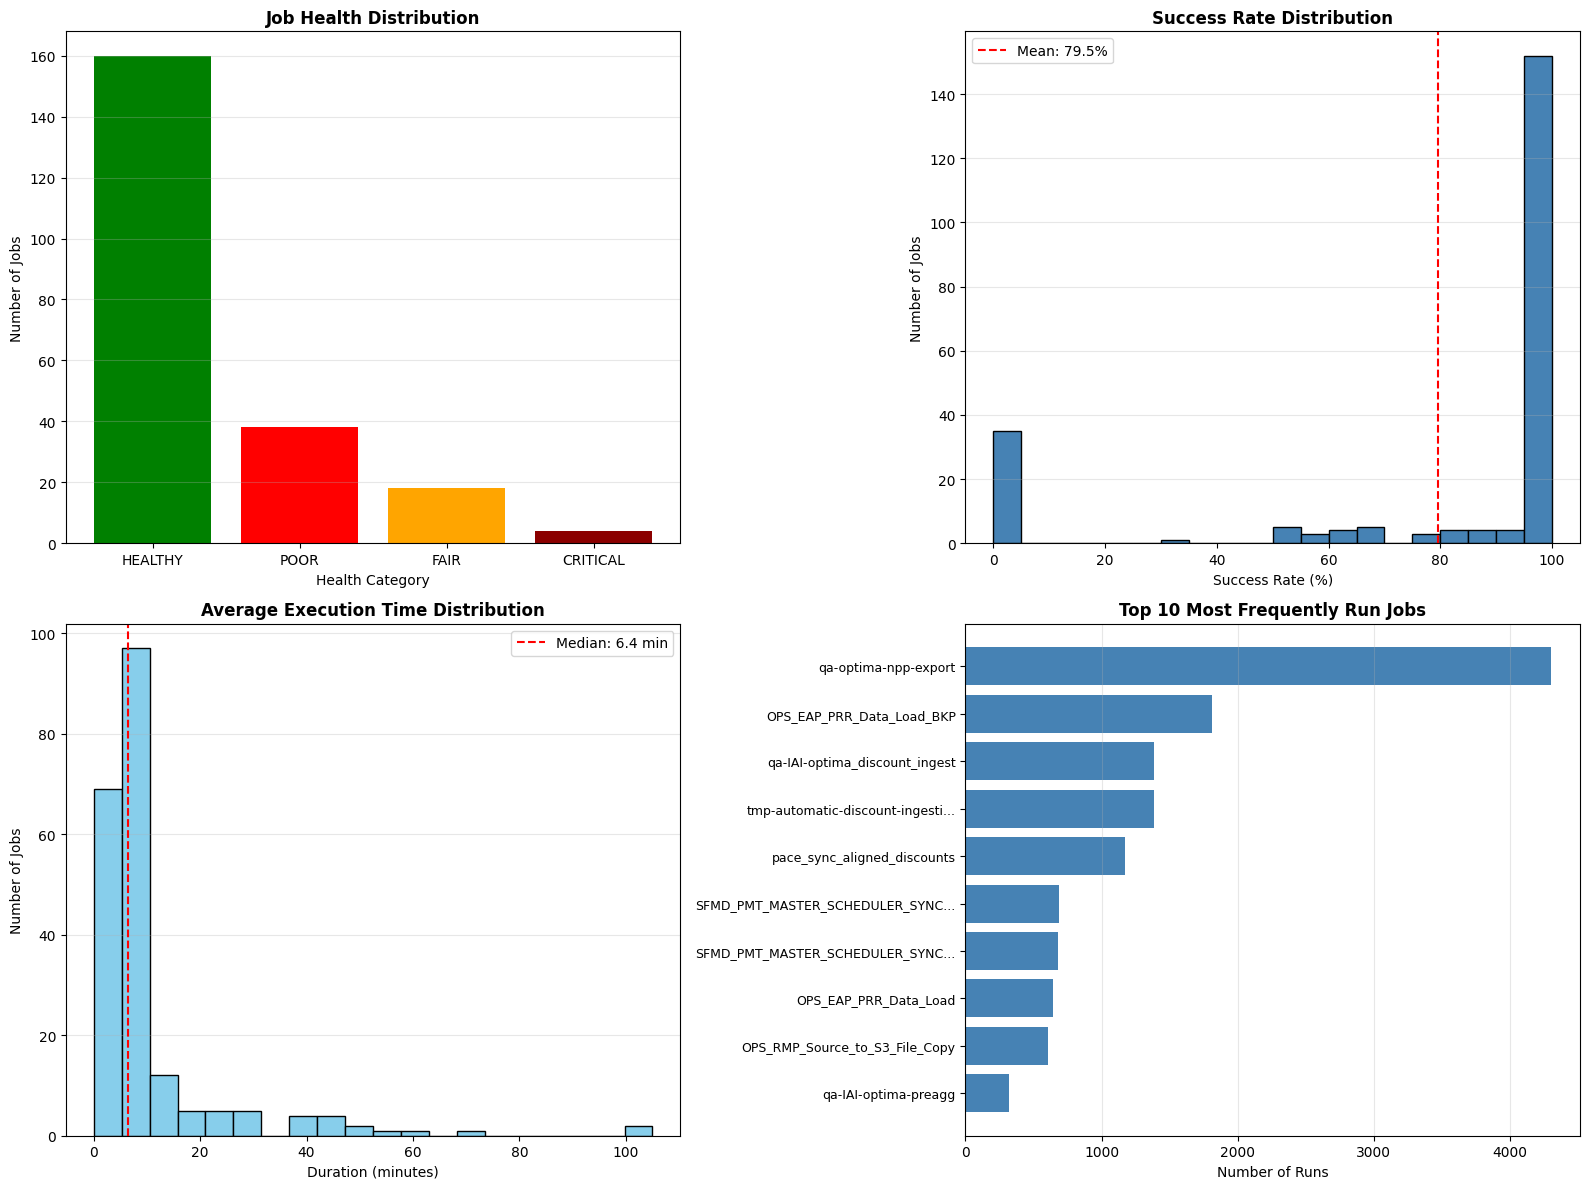

✓ Visualizations generated
⏱️  Visualizations completed in 10.56 seconds


In [0]:
cell_start_time = time.time()

if not is_job_mode and ENABLE_VISUALIZATIONS and job_metrics is not None:
    log("\n" + "="*60)
    log("VISUALIZATIONS")
    log("="*60)
    
    import matplotlib.pyplot as plt
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Chart 1: Health Category Distribution
    ax1 = axes[0, 0]
    health_dist = job_metrics.groupBy('health_category').count().toPandas()
    health_dist = health_dist.sort_values('count', ascending=False)
    colors = {'HEALTHY': 'green', 'FAIR': 'orange', 'POOR': 'red', 'CRITICAL': 'darkred'}
    bar_colors = [colors.get(cat, 'gray') for cat in health_dist['health_category']]
    ax1.bar(health_dist['health_category'], health_dist['count'], color=bar_colors)
    ax1.set_title('Job Health Distribution', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Health Category')
    ax1.set_ylabel('Number of Jobs')
    ax1.grid(axis='y', alpha=0.3)
    
    # Chart 2: Success Rate Distribution
    ax2 = axes[0, 1]
    success_rates = job_metrics.select('success_rate').toPandas()['success_rate'].dropna()
    ax2.hist(success_rates, bins=20, color='steelblue', edgecolor='black')
    ax2.axvline(success_rates.mean(), color='red', linestyle='--', label=f'Mean: {success_rates.mean():.1f}%')
    ax2.set_title('Success Rate Distribution', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Success Rate (%)')
    ax2.set_ylabel('Number of Jobs')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # Chart 3: Execution Time Distribution
    ax3 = axes[1, 0]
    durations = job_metrics.select('avg_duration_minutes').toPandas()['avg_duration_minutes'].dropna()
    durations_filtered = durations[durations < 120]  # Filter outliers for better visualization
    ax3.hist(durations_filtered, bins=20, color='skyblue', edgecolor='black')
    ax3.axvline(durations.median(), color='red', linestyle='--', label=f'Median: {durations.median():.1f} min')
    ax3.set_title('Average Execution Time Distribution', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Duration (minutes)')
    ax3.set_ylabel('Number of Jobs')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # Chart 4: Top 10 Jobs by Run Count (highest to lowest)
    ax4 = axes[1, 1]
    top_jobs = job_metrics.orderBy(F.desc('total_runs')).limit(10).toPandas()
    ax4.barh(range(len(top_jobs)), top_jobs['total_runs'], color='steelblue')
    ax4.set_yticks(range(len(top_jobs)))
    ax4.set_yticklabels([name[:30] + '...' if len(name) > 30 else name for name in top_jobs['job_name']], fontsize=9)
    ax4.invert_yaxis()  # Invert to show highest at top
    ax4.set_title('Top 10 Most Frequently Run Jobs', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Number of Runs')
    ax4.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    log("✓ Visualizations generated")
    
else:
    if is_job_mode:
        log("ℹ️  Visualizations skipped (job mode)")
    elif not ENABLE_VISUALIZATIONS:
        log("ℹ️  Visualizations disabled (ENABLE_VISUALIZATIONS=False)")
    else:
        log("ℹ️  Visualizations skipped (no data)")

log_execution_time("Visualizations", cell_start_time)

In [0]:
cell_start_time = time.time()

if ENABLE_EXCEL_EXPORT and job_metrics is not None:
    log("\n" + "="*60)
    log("EXPORTING TO EXCEL")
    log("="*60)
    
    try:
        # Create export directory
        if is_serverless:
            import tempfile
            temp_dir = tempfile.mkdtemp()
            export_path = temp_dir
        else:
            export_path = EXPORT_PATH
            os.makedirs(export_path, exist_ok=True)
        
        # Generate filename with timestamp
        timestamp = datetime.now(eastern).strftime('%Y%m%d_%H%M%S')
        excel_path = f"{export_path}/job_health_report_{timestamp}.xlsx"
        
        log(f"Creating Excel workbook: {excel_path}")
        
        # Convert DataFrames to Pandas
        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            # Sheet 1: Job Inventory
            jobs_df.toPandas().to_excel(writer, sheet_name='Job Inventory', index=False)
            
            # Sheet 2: Health Metrics
            job_metrics.orderBy(F.desc('health_score')).toPandas().to_excel(writer, sheet_name='Health Metrics', index=False)
            
            # Sheet 3: Problem Jobs
            if problem_jobs is not None and problem_jobs.count() > 0:
                problem_jobs.orderBy(F.desc('failure_rate')).toPandas().to_excel(writer, sheet_name='Problem Jobs', index=False)
            
            # Sheet 4: Recommendations
            if recommendations_df is not None:
                recommendations_df.toPandas().to_excel(writer, sheet_name='Recommendations', index=False)
            
            # Sheet 5: Summary Statistics
            summary_data = {
                'Metric': [
                    'Total Jobs',
                    'Total Runs Analyzed',
                    'Lookback Period (days)',
                    'Overall Success Rate (%)',
                    'Critical Jobs',
                    'Warning Jobs',
                    'Slow Jobs',
                    'Stale Jobs',
                    'Healthy Jobs',
                    'Analysis Date'
                ],
                'Value': [
                    jobs_df.count(),
                    job_metrics.agg(F.sum('total_runs')).first()[0],
                    LOOKBACK_DAYS,
                    f"{overall_success_rate:.1f}",
                    critical_count if 'critical_count' in dir() else 0,
                    warning_count if 'warning_count' in dir() else 0,
                    slow_count if 'slow_count' in dir() else 0,
                    stale_count if 'stale_count' in dir() else 0,
                    job_metrics.filter(F.col('health_category') == 'HEALTHY').count(),
                    datetime.now(eastern).strftime('%Y-%m-%d %H:%M:%S')
                ]
            }
            pd.DataFrame(summary_data).to_excel(writer, sheet_name='Summary', index=False)
            
            # Sheet 6: Execution Statistics
            stats_data = {
                'Metric': list(execution_stats.keys()),
                'Value': list(execution_stats.values())
            }
            pd.DataFrame(stats_data).to_excel(writer, sheet_name='Execution Stats', index=False)
        
        # Apply formatting
        from openpyxl import load_workbook
        from openpyxl.styles import Font, PatternFill, Alignment
        
        wb = load_workbook(excel_path)
        for sheet_name in wb.sheetnames:
            ws = wb[sheet_name]
            
            # Format header row
            for cell in ws[1]:
                cell.font = Font(bold=True, color='FFFFFF')
                cell.fill = PatternFill(start_color='366092', end_color='366092', fill_type='solid')
                cell.alignment = Alignment(horizontal='center')
            
            # Auto-adjust column widths
            for column in ws.columns:
                max_length = 0
                column_letter = column[0].column_letter
                for cell in column:
                    if cell.value:
                        max_length = max(max_length, len(str(cell.value)))
                ws.column_dimensions[column_letter].width = min(max_length + 2, 50)
        
        wb.save(excel_path)
        
        log(f"✓ Excel workbook created: {excel_path}")
        log(f"  Sheets: {len(wb.sheetnames)}")
        
    except Exception as e:
        log(f"✗ Excel export failed: {str(e)}")
else:
    if not ENABLE_EXCEL_EXPORT:
        log("ℹ️  Excel export disabled (ENABLE_EXCEL_EXPORT=False)")
    else:
        log("ℹ️  Excel export skipped (no data)")

log_execution_time("Excel Export", cell_start_time)

ℹ️  Excel export disabled (ENABLE_EXCEL_EXPORT=False)
⏱️  Excel Export completed in 0.01 seconds


In [0]:
cell_start_time = time.time()

if ENABLE_DELTA_EXPORT and job_metrics is not None:
    log("\n" + "="*60)
    log("EXPORTING TO DELTA TABLE")
    log("="*60)
    
    try:
        # Add audit metadata
        job_metrics_export = job_metrics.withColumn('audit_timestamp', F.current_timestamp())
        job_metrics_export = job_metrics_export.withColumn('lookback_days', F.lit(LOOKBACK_DAYS))
        job_metrics_export = job_metrics_export.withColumn('execution_time_seconds', F.lit(time.time() - execution_stats['start_time']))
        
        # Write to Delta table (append mode for historical tracking)
        job_metrics_export.write \
            .format('delta') \
            .mode('append') \
            .option('mergeSchema', 'true') \
            .saveAsTable(DELTA_TABLE_NAME)
        
        log(f"✓ Delta table updated: {DELTA_TABLE_NAME}")
        log(f"  Mode: append (historical retention)")
        log(f"  Rows added: {job_metrics.count()}")
        
    except Exception as e:
        log(f"✗ Delta export failed: {str(e)}")
else:
    if not ENABLE_DELTA_EXPORT:
        log("ℹ️  Delta export disabled (ENABLE_DELTA_EXPORT=False)")
    else:
        log("ℹ️  Delta export skipped (no data)")

log_execution_time("Delta Export", cell_start_time)

ℹ️  Delta export disabled (ENABLE_DELTA_EXPORT=False)
⏱️  Delta Export completed in 0.03 seconds


In [0]:
# ============================================================================
# EXECUTION SUMMARY
# ============================================================================

execution_time = time.time() - execution_stats['start_time']

log("\n" + "="*60)
log("EXECUTION SUMMARY")
log("="*60)

log(f"\n⏱️  Total execution time: {execution_time:.2f} seconds")
log(f"\n📊 Statistics:")
log(f"  Jobs analyzed: {execution_stats['jobs_processed']}")
log(f"  Runs analyzed: {execution_stats['runs_processed']}")
log(f"  API calls: {execution_stats['api_calls']}")
log(f"  API failures: {execution_stats['api_failures']}")
log(f"  API retries: {execution_stats['api_retries']}")

if execution_stats['api_calls'] > 0:
    success_rate = ((execution_stats['api_calls'] - execution_stats['api_failures']) / execution_stats['api_calls']) * 100
    log(f"  API success rate: {success_rate:.1f}%")

if job_metrics is not None:
    log(f"\n🏥 Job Health Summary:")
    log(f"  Healthy jobs: {job_metrics.filter(F.col('health_category') == 'HEALTHY').count()}")
    log(f"  Fair jobs: {job_metrics.filter(F.col('health_category') == 'FAIR').count()}")
    log(f"  Poor jobs: {job_metrics.filter(F.col('health_category') == 'POOR').count()}")
    log(f"  Critical jobs: {job_metrics.filter(F.col('health_category') == 'CRITICAL').count()}")
    
    avg_health = job_metrics.agg(F.avg('health_score')).first()[0]
    log(f"\n  Average health score: {avg_health:.1f}/100")

if recommendations_df is not None:
    log(f"\n💡 Recommendations: {recommendations_df.count()}")

log("\n" + "="*60)
log("✓ JOB & WORKFLOW HEALTH ANALYSIS COMPLETE")
log("="*60)

# Return JSON summary for job mode
if is_job_mode:
    import json
    summary = {
        'status': 'success',
        'execution_time_seconds': execution_time,
        'jobs_analyzed': execution_stats['jobs_processed'],
        'runs_analyzed': execution_stats['runs_processed'],
        'problem_jobs': problem_jobs.count() if problem_jobs is not None else 0,
        'recommendations': recommendations_df.count() if recommendations_df is not None else 0,
        'timestamp': datetime.now(eastern).isoformat()
    }
    dbutils.notebook.exit(json.dumps(summary))


EXECUTION SUMMARY

⏱️  Total execution time: 75.84 seconds

📊 Statistics:
  Jobs analyzed: 741
  Runs analyzed: 16579
  API calls: 0
  API failures: 0
  API retries: 0

🏥 Job Health Summary:
  Healthy jobs: 160
  Fair jobs: 18
  Poor jobs: 38
  Critical jobs: 4

  Average health score: 84.9/100

💡 Recommendations: 73

✓ JOB & WORKFLOW HEALTH ANALYSIS COMPLETE
